In this project we will train two models on the UCI Wine Quality Dataset (https://archive.ics.uci.edu/dataset/186/wine+quality). Both models will be predicting the quality score of wines, given the other variables and the colour of the wine. We will first perform an OLS linear regression, and then train an artificial neural network, before comparing the two.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Firstly, we will need to import and process our data. It is formatted slightly differently, so we will first make it into a pandas dataframe, combining red and white wines. I have added a binary colour column denoting whether the wine is red or white.

In [2]:
# Import data
dfw = pd.read_csv('winequality-white.csv', header = None)
dfr = pd.read_csv('winequality-red.csv', header = None)

In [3]:
column_labels = dfw.iloc[0].str.split(';').values[0]

dfw = dfw[1:].apply(lambda x: x.str.split(';').values[0], axis = 1)
dfr = dfr[1:].apply(lambda x: x.str.split(';').values[0], axis = 1)

dfw = pd.DataFrame(dfw.tolist())
dfr = pd.DataFrame(dfr.tolist())

dfw.columns = column_labels
dfr.columns = column_labels

In [4]:
# Add a colour column for denoting whether the wine is white or red
dfr.insert(loc = len(dfr.columns) - 1, column = "colour", value = 1)
dfw.insert(loc = len(dfw.columns) - 1, column = "colour", value = 0)

In [5]:
# Combine the white and red wine dataframes, and then 'shuffle' them
df = pd.concat([dfw,dfr], ignore_index = True)

shuffled_df = df.sample(frac = 1, random_state = 42)
shuffled_df = shuffled_df.astype(float)

In [6]:
shuffled_df

,fixed acidity,"""volatile acidity""","""citric acid""","""residual sugar""","""chlorides""","""free sulfur dioxide""","""total sulfur dioxide""","""density""","""pH""","""sulphates""","""alcohol""",colour,"""quality"""
3103,7.0,0.25,0.45,2.3,0.045,40.0,118.0,0.99064,3.16,0.48,11.9,0.0,7.0
1419,7.6,0.14,0.74,1.6,0.040,27.0,103.0,0.99160,3.07,0.40,10.8,0.0,7.0
4761,6.2,0.15,0.27,11.0,0.035,46.0,116.0,0.99602,3.12,0.38,9.1,0.0,6.0
4690,6.7,0.16,0.32,12.5,0.035,18.0,156.0,0.99666,2.88,0.36,9.0,0.0,6.0
4032,6.8,0.27,0.22,17.8,0.034,16.0,116.0,0.99890,3.07,0.53,9.2,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,6.3,0.24,0.29,13.7,0.035,53.0,134.0,0.99567,3.17,0.38,10.6,0.0,6.0
5191,6.9,0.36,0.25,2.4,0.098,5.0,16.0,0.99640,3.41,0.60,10.1,1.0,6.0
5226,13.4,0.27,0.62,2.6,0.082,6.0,21.0,1.00020,3.16,0.67,9.7,1.0,6.0
5390,8.9,0.40,0.51,2.6,0.052,13.0,27.0,0.99500,3.32,0.90,13.4,1.0,7.0


In [7]:
# Set up arrays for training
X = shuffled_df.iloc[:, :-1].to_numpy()
Y = shuffled_df.iloc[:,-1].to_numpy()

In [8]:
# Create a train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    random_state = 21)

In [9]:
# A measure of loss (Mean Absolute Error) which will come in handy later
def loss1(true, pred):
    return abs(true-pred).mean()

We can now begin modelling. We will first begin with an OLS linear regression which have an analytic solution (and can be computed using models such as the one in sklearn).

In [10]:
model_l = LinearRegression()
model_l.fit(X_train, Y_train)

LinearRegression()

In [11]:
# Work out average loss
test_preds_l = model_l.predict(X_test)
test_loss_l = loss1(Y_test, test_preds_l)

# Round the results of our model and work out accuracy
def accuracy(preds, real):
    rounded_preds = np.round(preds).astype(int)
    cumsum = 0
    for i in range(len(preds)):
        if rounded_preds[i] == real[i]:
            cumsum += 1
    return cumsum/len(preds) * 100

test_acc_l = accuracy(test_preds_l, Y_test)

In [12]:
print(f'The loss is {test_loss_l:.4f} for the linear regression model. This means that on average, our prediction is {test_loss_l:.4f} away from the actual result.')
print(f'The accuracy of the linear regression model is {test_acc_l:.2f}%.')

The loss is 0.6017 for the linear regression model. This means that on average, our prediction is 0.6017 away from the actual result.
The accuracy of the linear regression model is 50.54%.


Below we have created a table which allows us to roughly see how the different variables affect the quality score predictions (in this particular model).

In [13]:
column_labels.pop()
column_labels.append('"colour"')
coefficients = pd.DataFrame([model_l.coef_],
                            columns = column_labels)
print(f'The intercept for this model is quite high ({model_l.intercept_:.4}), meaning that factors which negatively affect quality are going to have negative coefficients, while factors that positively affect quality will have smaller positive coefficients.')
coefficients

The intercept for this model is quite high (94.53), meaning that factors which negatively affect quality are going to have negative coefficients, while factors that positively affect quality will have smaller positive coefficients.


,fixed acidity,"""volatile acidity""","""citric acid""","""residual sugar""","""chlorides""","""free sulfur dioxide""","""total sulfur dioxide""","""density""","""pH""","""sulphates""","""alcohol""","""colour"""
0,0.086088,-1.513881,-0.144165,0.05893,-0.668972,0.003759,-0.001191,-93.837554,0.401612,0.781722,0.240924,0.321116


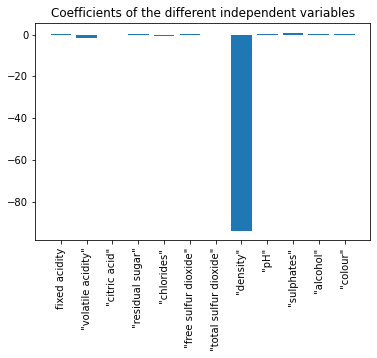

In [14]:
plt.bar(column_labels, model_l.coef_)
plt.title('Coefficients of the different independent variables')
plt.xticks(rotation = 90)
plt.show()

From the bar chart above, it looks like density strongly negatively effects the quality. We will make another bar plot where we can observe the other variables more closely.

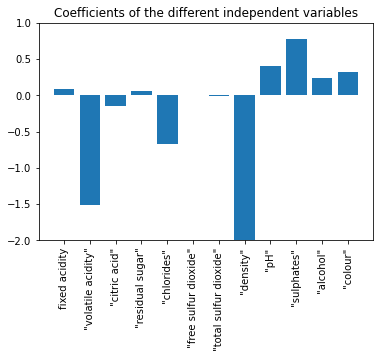

In [15]:
plt.bar(column_labels, model_l.coef_)
plt.title('Coefficients of the different independent variables')
plt.xticks(rotation = 90)
plt.ylim(-2, 1)
plt.show()

Here we can see that pH, solphates, alcohol seem to affect the quality positively. Also, in general, red wine seems to be preferred to white wine. The volatile acidity and presence of chlorides seem to affect quality negatively.

Now we will try to beat this with a simple artificial neural network.

In [16]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [17]:
# Convert arrays from before to PyTorch tensors
X_train = torch.tensor(X_train).type(torch.float).to(device)
X_test = torch.tensor(X_test).type(torch.float).to(device)
Y_train = torch.tensor(Y_train).type(torch.float).to(device)
Y_test = torch.tensor(Y_test).type(torch.float).to(device)

In [18]:
# Set up model class
nodes = 64

class WineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Sequential(nn.Linear(12, nodes), 
                                   nn.ReLU())
        self.mid = nn.Sequential(nn.Linear(nodes, nodes), 
                                 nn.ReLU(),
                                nn.Linear(nodes, nodes), 
                                 nn.ReLU())
        self.output = nn.Linear(nodes, 1)
        
    def forward(self, x):
        return self.output(self.mid(self.input(x)))

In [19]:
# Make instance of the class and set up MSE loss and SGD optimiser
model_n = WineModel().to(device)

loss2 = nn.MSELoss()
optim = torch.optim.SGD(params = model_n.parameters(), lr = 0.0005)

In [20]:
def training_step(epoch):
    model_n.train()
    train_preds = model_n(X_train).squeeze()
    train_loss = loss2(train_preds, Y_train)
    optim.zero_grad()
    train_loss.backward()
    optim.step()
    
    
def test_step(epoch):
    if epoch % 1000 == 0:
        model_n.eval()
        with torch.inference_mode():
            test_preds_n = model_n(X_test).squeeze()
            test_loss_n = loss1(test_preds_n, Y_test)
    
        print(f'Test loss is {test_loss_n.item()}. Epoch {epoch}, {epoch/epochs * 100:.0f}% done')

In [21]:
# Train the neural network
epochs = 100000
for epoch in range(epochs):
    training_step(epoch)
    test_step(epoch)

Test loss is 4.239583969116211. Epoch 0, 0% done
Test loss is 0.7426581978797913. Epoch 1000, 1% done
Test loss is 0.6868343353271484. Epoch 2000, 2% done
Test loss is 0.6623643040657043. Epoch 3000, 3% done
Test loss is 0.6521697640419006. Epoch 4000, 4% done
Test loss is 0.646380603313446. Epoch 5000, 5% done
Test loss is 0.6446167826652527. Epoch 6000, 6% done
Test loss is 0.6368417143821716. Epoch 7000, 7% done
Test loss is 0.6367495059967041. Epoch 8000, 8% done
Test loss is 0.636471688747406. Epoch 9000, 9% done
Test loss is 0.6290748119354248. Epoch 10000, 10% done
Test loss is 0.6297575235366821. Epoch 11000, 11% done
Test loss is 0.6285094022750854. Epoch 12000, 12% done
Test loss is 0.6250753998756409. Epoch 13000, 13% done
Test loss is 0.6284008026123047. Epoch 14000, 14% done
Test loss is 0.6294510960578918. Epoch 15000, 15% done
Test loss is 0.6220916509628296. Epoch 16000, 16% done
Test loss is 0.6250001788139343. Epoch 17000, 17% done
Test loss is 0.6212825775146484. Epo

In [22]:
test_preds_n = model_n(X_test).squeeze()
test_loss_n = loss1(test_preds_n, Y_test)
test_acc_n = accuracy(test_preds_n.cpu().detach().numpy(), Y_test)

print(f'Loss is {test_loss_n:.4f} for the neural network model, as compared to {test_loss_l:.4f} for the linear regression.')
print(f'Neural network accuracy is {test_acc_n:.2f}% while linear regression accuracy is {test_acc_l:.2f}%.')

Loss is 0.5984 for the neural network model, as compared to 0.6017 for the linear regression.
Neural network accuracy is 53.00% while linear regression accuracy is 50.54%.


This means that despite the extra time and computational power required to train a neural network, we have very comparable results. Furthermore, it is far more easy to infer things from a linear regression, as seen when we analysed the coefficients of our model earlier.

It should be noted that this does not objectively prove that linear regressions are better than neural networks; in the case that data has more complicated relationships between variables, a neural network will almost certainly be preferable.

However, we have shown that, when working with sufficiently 'simple' data, linear regressions are both easier to implement and as capable. To be more precise, 'simple' here refers to data having linear relationships between variables, or at least a close approximation to them.